# **Exploratory Data Analysis of Facebook News Reactions**

This notebook performs exploratory data analysis (EDA) on a dataset containing Facebook reactions to news articles from various news organizations. The goal is to understand the distribution of reactions, the sentiment of news articles, and how different reactions correlate with each other and with the sentiment scores.

## **1. Import Libraries**

First, we import the necessary libraries for data manipulation, visualization, and text processing.

In [1]:
# # Mount Google Drive (if using Google Colab)
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
from collections import Counter
import nltk

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/francescascipioni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/francescascipioni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/francescascipioni/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## **2. Load Data**

We load the dataset containing Facebook reactions to news articles.

In [3]:
# # From Colab
# path = '/content/drive/MyDrive/DATASCI-266_FinalProject/combined_VERY_VERY_FINAL.csv'

# or from local machine
path = 'combined_VERY_VERY_FINAL.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(path)

## **3. Data Overview**

We check the columns and basic information about the dataset.

In [4]:
# Display the column names
print(df.columns)

# Display information about the DataFrame
df.info()

Index(['news_org', 'title', 'summary', 'total_reactions',
       'article_screenshot_s3_link', 'reactions_screenshot_s3_link',
       'article_sc_date', 'reactions_sc_date', 'total_comments',
       'total_shares', 'total_like', 'total_love', 'total_haha', 'total_wow',
       'total_sad', 'total_angry', 'total_care', 'ratio_love', 'ratio_haha',
       'ratio_wow', 'ratio_sad', 'ratio_angry', 'ratio_care', 'cleaned_title',
       'cleaned_summary', 'vader_sentiment_score', 'embedding',
       'vader_sentiment_class', 'sentiment_score', 'headline_sentiment_class',
       'news_label'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6622 entries, 0 to 6621
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   news_org                      6622 non-null   object 
 1   title                         6622 non-null   object 
 2   summary                       6622 non-

## **4. Define Color Palette and Paths**

We define a color palette for consistent plotting and specify paths for output images and icons.

In [28]:
# Define a color palette (colors used in Facebook reactions)
like_blue = "#0084ff"
heart_red = "#fa3c4c"
fb_yellow = "#ffc300"
fb_pink = "#d696bb"
fb_green = "#67b868"
fb_dark_blue = "#2D3D57"

# Set the default plot color
plot_color = 'black'

# Define paths for saving plots and accessing icons

# # From Colab
# icons_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/Icons/'
# path_output_images = '/content/drive/MyDrive/DATASCI-266_FinalProject/Plots/'

# Or from local machine
path_output_images = 'Plots/'
icons_path = 'Presentation/Icons/'

## **5. Plot 1: Percentage of “Like” Reactions Compared to Others**

### **5.1 Calculate Percentages**

We calculate the percentage of “Like” reactions compared to all other reactions across all news organizations.

In [6]:
# Define reaction types
reaction_types = ['total_like', 'total_love', 'total_haha', 'total_wow',
                  'total_sad', 'total_angry', 'total_care']

# Group the data by 'news_org' and sum the reaction counts
grouped = df.groupby('news_org')[reaction_types].sum().reset_index()

# Calculate the sum of all reactions except 'total_like'
grouped['other_reactions'] = grouped[reaction_types[1:]].sum(axis=1)

# Calculate the total reactions for each news organization
grouped['total_reactions'] = grouped['total_like'] + grouped['other_reactions']

# Calculate percentage for 'total_like' and 'other_reactions'
grouped['total_like_percent'] = (grouped['total_like'] / grouped['total_reactions']) * 100
grouped['other_reactions_percent'] = (grouped['other_reactions'] / grouped['total_reactions']) * 100

# Calculate overall totals and percentages
likes_tot = df['total_like'].sum()
other_tot = df[reaction_types[1:]].sum().sum()
total_reactions = likes_tot + other_tot

like_percent = round((likes_tot / total_reactions) * 100)
other_percent = round((other_tot / total_reactions) * 100)

print(f"Total Likes: {likes_tot} ({like_percent}%)")
print(f"Total Other Reactions: {other_tot} ({other_percent}%)")

Total Likes: 2391073 (62%)
Total Other Reactions: 1446707 (38%)


### **5.2 Plotting**

We create a scatter plot showing the percentage of “Like” reactions versus the percentage of all other reactions for each news organization.

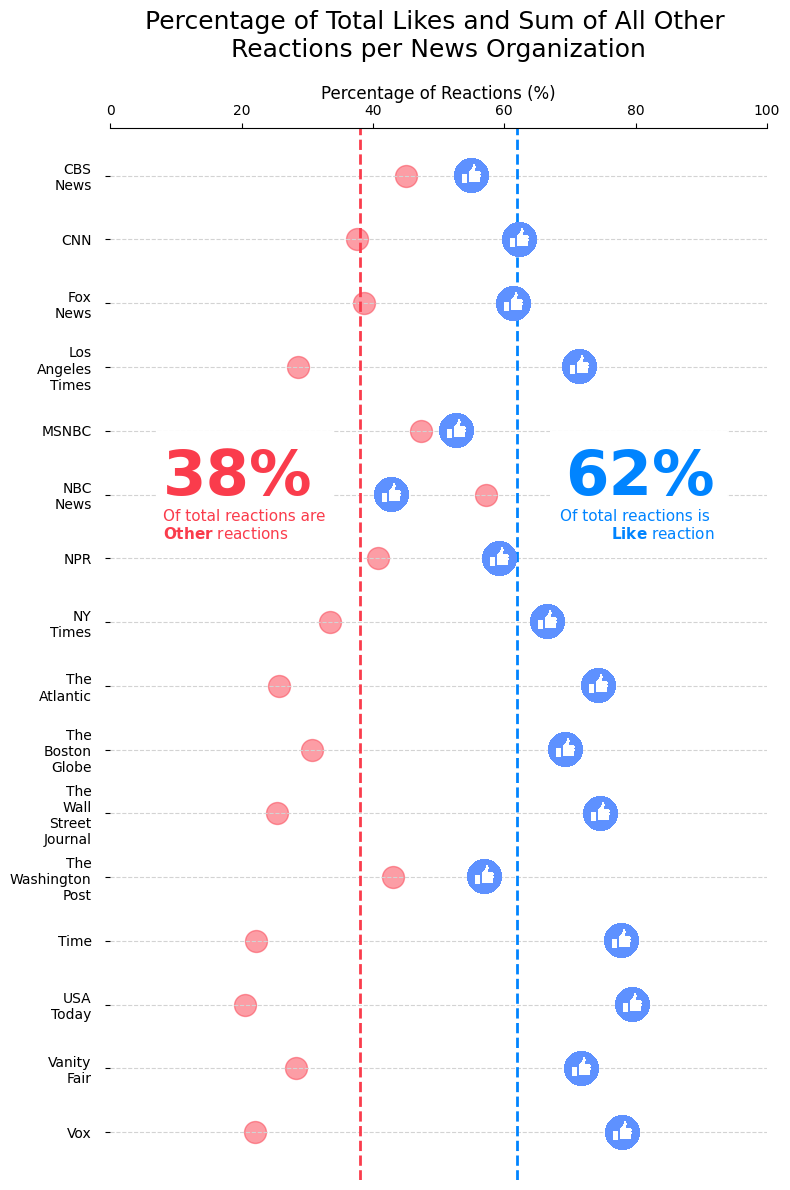

In [7]:
# Sort the grouped DataFrame by 'news_org'
grouped = grouped.sort_values(by='news_org', ascending=False)

# Prepare the DataFrame for plotting
plot_df = grouped[['news_org', 'total_like_percent', 'other_reactions_percent']]

# Format news organization names
plot_df['news_org'] = plot_df['news_org'].str.replace('_', ' ')

# Get positions for y-axis
news_orgs = plot_df['news_org']
y_positions = range(len(news_orgs))

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 12), facecolor='none')  # Outer background transparent
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_color(plot_color)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()

# Set light gray grid lines
ax.grid(axis='y', color='lightgray', linestyle='--')
ax.grid(axis='x', visible=False)

# Draw vertical lines representing overall percentages
ax.axvline(x=other_percent, color=heart_red, linestyle='--', linewidth=2)
ax.axvline(x=like_percent, color=like_blue, linestyle='--', linewidth=2)

# Add white rectangles
rect1 = patches.Rectangle(
    (7, 9),
    width=27,
    height=2,
    facecolor = 'white',
    linewidth=0,
    edgecolor=None,
    zorder=3
    )
ax.add_patch(rect1)

rect2 = patches.Rectangle(
    (67, 9),
    width=27,
    height=2,
    facecolor = 'white',
    linewidth=0,
    edgecolor=None,
    zorder=3
    )
ax.add_patch(rect2)

# Add text annotations for overall percentages
ax.text(8, 10, f'{other_percent}%', fontsize=45, color=heart_red, ha='left', weight='black')
ax.text(8, 9.3, 'Of total reactions are \n$\mathbf{Other}$ reactions', fontsize=11, color=heart_red, ha='left')
ax.text(92, 10, f'{like_percent}%', fontsize=45, color=like_blue, ha='right', weight='black')
ax.text(92, 9.3, 'Of total reactions is \n$\mathbf{Like}$ reaction', fontsize=11, color=like_blue, ha='right')

# Plot 'other_reactions_percent' using scatter
ax.scatter(plot_df['other_reactions_percent'], y_positions, marker='o', color=heart_red, alpha=0.5, s=250)

# Load the 'like.png' image
like_img = mpimg.imread(icons_path + 'like.png')

# Plot 'total_like_percent' using the image as marker
for x, y in zip(plot_df['total_like_percent'], y_positions):
    # Create an OffsetImage
    imagebox = OffsetImage(like_img, zoom=0.01)  # Adjust 'zoom' to scale the image
    # Create an AnnotationBbox
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)

# Add labels and title
ax.set_yticks(y_positions)
ax.set_yticklabels([label.replace(" ", "\n") for label in news_orgs],
                   rotation=0,
                   ha='right',
                   color=plot_color)
ax.tick_params(axis='y', pad=10)
ax.set_xlabel('Percentage of Reactions (%)', size=12, color=plot_color)
ax.xaxis.set_label_position('top')
ax.set_title('Percentage of Total Likes and Sum of All Other \nReactions per News Organization',
             size=18,
             color=plot_color,
             pad=20)
ax.tick_params(colors=plot_color)
ax.set_xlim(0, 100)
plt.tight_layout()

# Save and display the plot
plt.savefig(path_output_images + 'plot_percentage_likes_vs_other_reactions.png', transparent=True)
plt.show()

## **6. Plot 2: Percentage of Individual Reactions per News Organization (Excluding Like)**

We analyze the distribution of reactions (excluding “Like”) for each news organization.


### **6.1 Prepare Data**

In [8]:
# Reaction types excluding "total_like"
reaction_types = ['total_love', 'total_haha', 'total_wow', 'total_sad', 'total_angry', 'total_care']
reactions_names = ['love', 'haha', 'wow', 'sad', 'angry', 'care']

# Group the data by 'news_org' and sum the reaction counts
grouped = df.groupby('news_org')[reaction_types].sum().reset_index()

# Calculate the total reactions excluding 'like' for each news organization
grouped['total_reactions'] = grouped[reaction_types].sum(axis=1)
grouped = grouped.sort_values(by='news_org', ascending=False)

# Calculate the percentage for each individual reaction type
for reaction in reaction_types:
    grouped[f'{reaction}_percent'] = (grouped[reaction] / grouped['total_reactions']) * 100

# Prepare the DataFrame for plotting
plot_df = grouped[['news_org'] + [f'{reaction}_percent' for reaction in reaction_types]]

# Format news organization names
plot_df['news_org'] = plot_df['news_org'].str.replace('_', ' ')

### **6.2 Plotting**

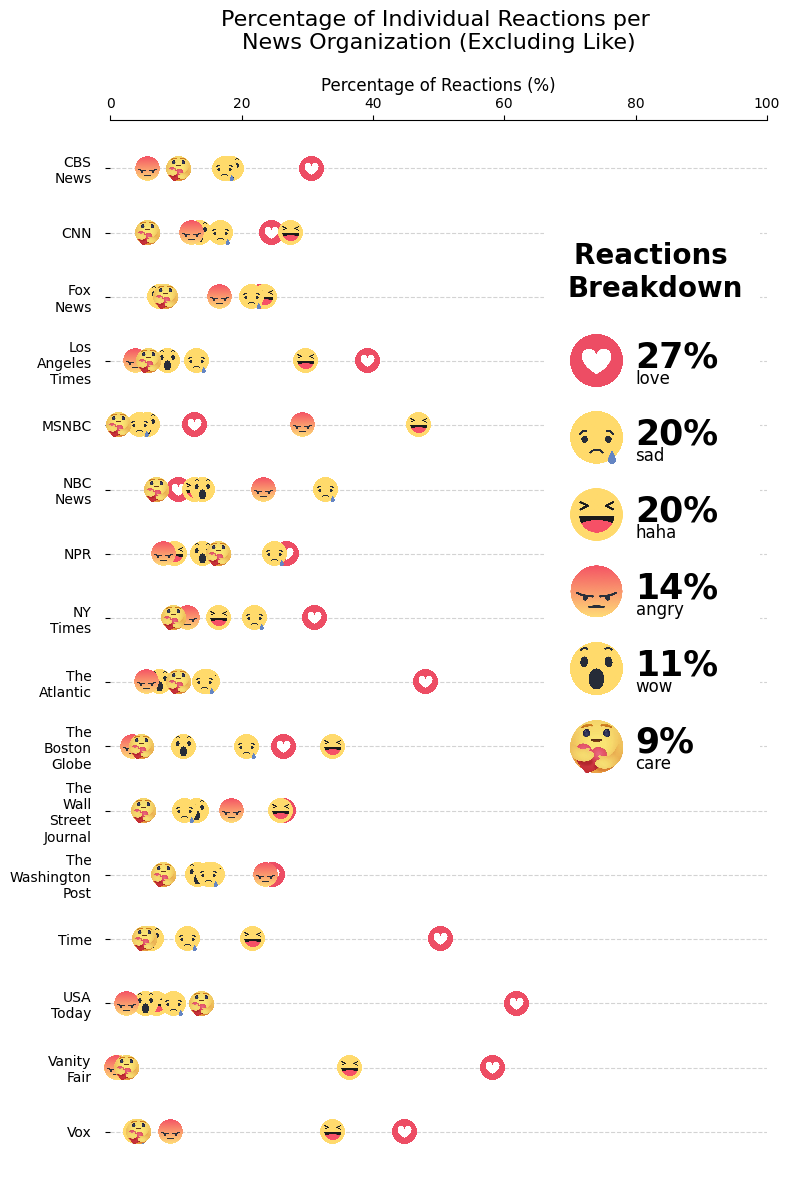

In [9]:
# Get positions for y-axis
news_orgs = plot_df['news_org']
y_positions = range(len(news_orgs))

# Load images for each reaction type
reaction_images = {
    'total_love': mpimg.imread(icons_path + 'love.png'),
    'total_haha': mpimg.imread(icons_path + 'haha.png'),
    'total_wow': mpimg.imread(icons_path + 'wow.png'),
    'total_sad': mpimg.imread(icons_path + 'sad.png'),
    'total_angry': mpimg.imread(icons_path + 'angry.png'),
    'total_care': mpimg.imread(icons_path + 'care.png')
}

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 12), facecolor='none')
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_color(plot_color)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.grid(axis='y', color='lightgray', linestyle='--')
ax.grid(axis='x', visible=False)

x_positions = [1] * len(y_positions)  # Creates an array of 1s with the same length as y_positions
ax.scatter(x_positions, y_positions, marker='o', color='white', alpha=0.9, s=1)

# Plot each reaction's percentages using images
for reaction in reaction_types:
    for x, y in zip(plot_df[f'{reaction}_percent'], y_positions):
        # Create an OffsetImage
        imagebox = OffsetImage(reaction_images[reaction], zoom=0.007)
        # Create an AnnotationBbox
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        # Add the AnnotationBbox to the plot
        ax.add_artist(ab)

# Calculate overall percentages of reactions
reaction_totals = df[reaction_types].sum()
reaction_percentages = (reaction_totals / reaction_totals.sum()) * 100

# Create a summary table on the plot
rect = patches.Rectangle((66, 5.2), width=33, height=8.9, facecolor='white', linewidth=0, edgecolor=None, zorder=3)
ax.add_patch(rect)

# Plot the summary of reactions
reaction_data = pd.DataFrame({
    'reaction': reaction_types,
    'percentage': reaction_percentages.values,
    'names': reactions_names
}).sort_values(by='percentage', ascending=False).reset_index(drop=True)


for i, row in reaction_data.iterrows():
    reaction = row['reaction']
    percent = row['percentage']
    name = row['names']
    # Image and text annotations
    imagebox = OffsetImage(reaction_images[reaction], zoom=0.015)
    ab = AnnotationBbox(imagebox, (74, 12 - (i * 1.2)), frameon=False)
    ax.add_artist(ab)
    ax.text(80, 11.9 - (i * 1.2), f"{percent:.0f}%", ha='left', fontsize=25, color=plot_color, weight='black')
    ax.text(80, 11.9 - (i * 1.2 + 0.25), f"{name}", ha='left', fontsize=12, color=plot_color)

# Add title and labels
ax.text(83, 13, "Reactions \nBreakdown", ha='center', fontsize=20, color=plot_color, weight='demibold')
ax.set_yticks(y_positions)
ax.set_yticklabels([label.replace(" ", "\n") for label in news_orgs], rotation=0, ha='right', color=plot_color)
ax.tick_params(axis='y', pad=10)
ax.set_xlabel('Percentage of Reactions (%)', size=12, color=plot_color)
ax.xaxis.set_label_position('top')
ax.set_title('Percentage of Individual Reactions per \nNews Organization (Excluding Like)',
             size=16,
             color=plot_color,
             pad=20)
ax.tick_params(colors=plot_color)
ax.set_xlim(0, 100)
plt.tight_layout()

# Save and display the plot
plt.savefig(path_output_images + 'plot_percentage_individual_reactions_news_org.png', transparent=True)
plt.show()

## **7. Plot 3: Histogram of Sentiment Score Frequencies**

We create a histogram to visualize the distribution of positive and negative sentiment scores.


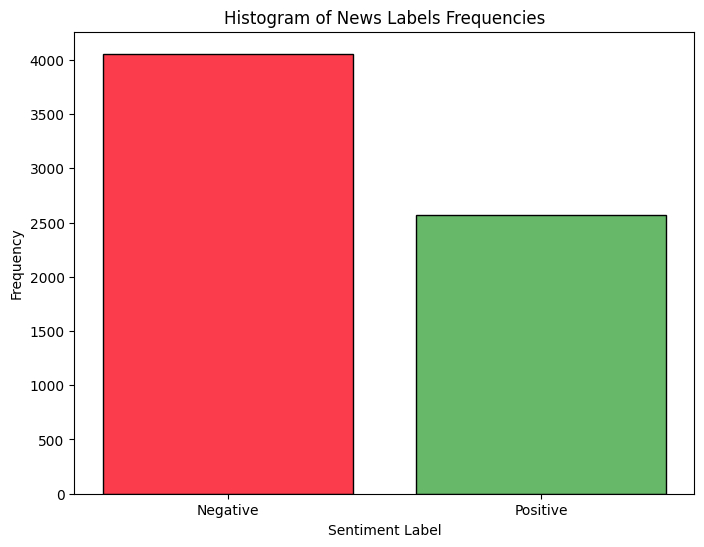

In [10]:
# Calculate frequencies for each label
counts = df['news_label'].value_counts()
labels = [0, 1]  # 1: Positive, 0: Negative
colors = [heart_red, fb_green]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=colors, edgecolor='black', align='center')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Histogram of News Labels Frequencies')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

In [11]:
counts

news_label
0    4056
1    2566
Name: count, dtype: int64

## **8. Plot 4: Positive/Negative Title Distribution by News Organization**

We analyze how positive and negative titles are distributed across different news organizations.

### **8.1 Prepare Data**

In [12]:
# Calculate counts of positive and negative titles per news organization
title_distribution = df.groupby(['news_org', 'news_label']).size().unstack(fill_value=0)

# Rename columns for better readability
title_distribution.columns = ['Negative', 'Positive']

# Add a new column for the total number of news articles for each organization
title_distribution['Total'] = title_distribution['Negative'] + title_distribution['Positive']

# Sort by the Total column in descending order
title_distribution = title_distribution.sort_values(by='Total')

# Drop the 'Total' column if you don't need it after sorting
title_distribution = title_distribution.drop(columns=['Total'])

### **8.2 Plotting**

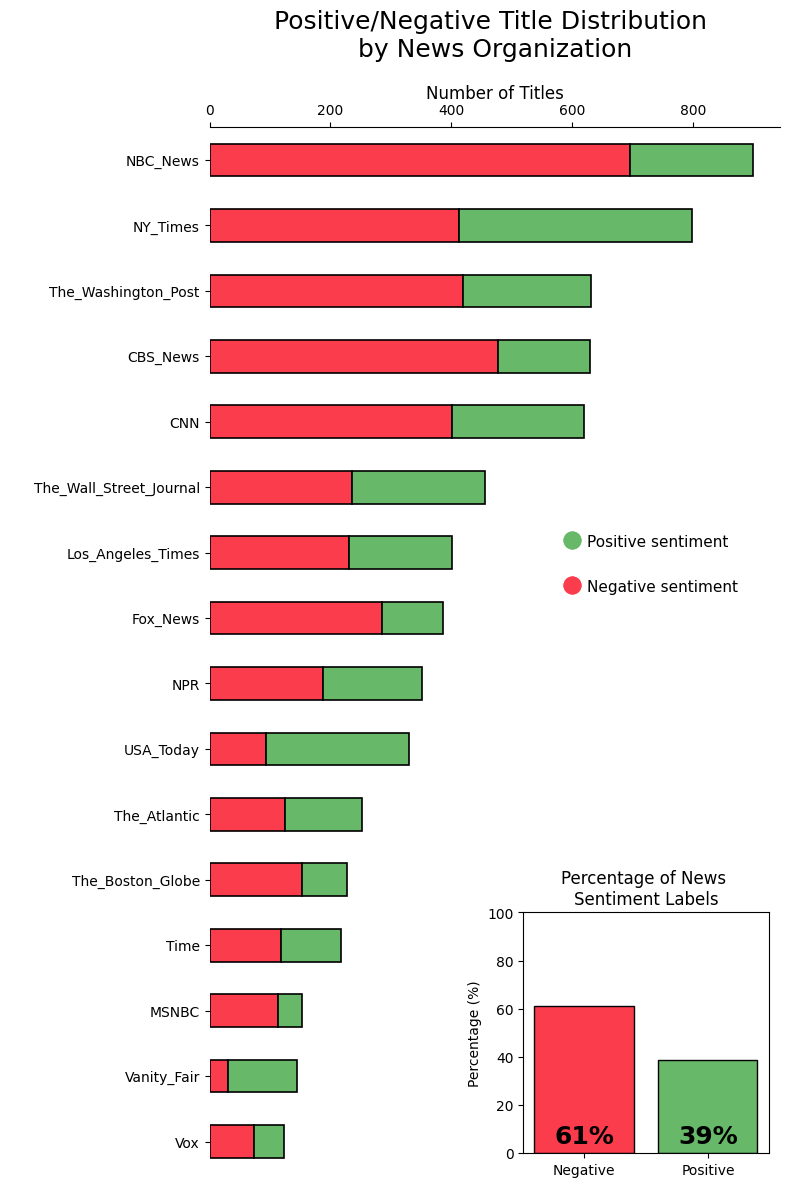

In [13]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 12))
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_color(plot_color)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()

# Plot the distribution with horizontal bars
title_distribution.plot(kind='barh',
                        stacked=True,
                        color=[heart_red, fb_green],
                        ax=ax,
                        edgecolor=plot_color,
                        linewidth=1.2)

# Add labels and title
ax.set_xlabel('Number of Titles', size=12, color=plot_color)
ax.set_ylabel(' ', size=12, color=plot_color)
ax.xaxis.set_label_position('top')
ax.set_title('Positive/Negative Title Distribution \nby News Organization',
             size=18,
             color=plot_color,
             pad=20)
ax.legend_.remove()

# Add a legend inside the plot
ax.plot([600, 600], [8.5, 8.5], color=heart_red, marker='o', markersize=12)
ax.text(625, 8.4, "Negative sentiment", fontsize=11, color=plot_color, ha='left')
ax.plot([600, 600], [9.2, 9.2], color=fb_green, marker='o', markersize=12)
ax.text(625, 9.1, "Positive sentiment", fontsize=11, color=plot_color, ha='left')

# Barplot inset showing overall percentages
counts = df['news_label'].value_counts()
total = counts.sum()
percentages = (counts / total) * 100
labels = [0, 1]
colors = [heart_red, fb_green]

ax1 = ax.inset_axes([0.55, 0.02, 0.43, 0.23])
bars = ax1.bar(labels, percentages, color=colors, edgecolor='black', align='center')

# Add percentages as text on the bars
for bar, percentage in zip(bars, percentages):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        2,
        f'{percentage:.0f}%',
        ha='center',
        va='bottom',
        fontsize=18,
        color='black',
        weight='black'
    )

# Customize the inset plot
ax1.set_ylabel('Percentage (%)')
ax1.set_ylim(0, 100)
ax1.set_title('Percentage of News \nSentiment Labels')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Negative', 'Positive'])

# Adjust layout
plt.tight_layout()

# Save and display the plot
plt.savefig(path_output_images + 'Positive_Negative_Title_Distribution_News_Organization.png', transparent=True)
plt.show()

## **9. Plot 5: Scatter Plot of Total Reactions vs Sentiment Score**

We explore the relationship between the total number of reactions and the sentiment scores.

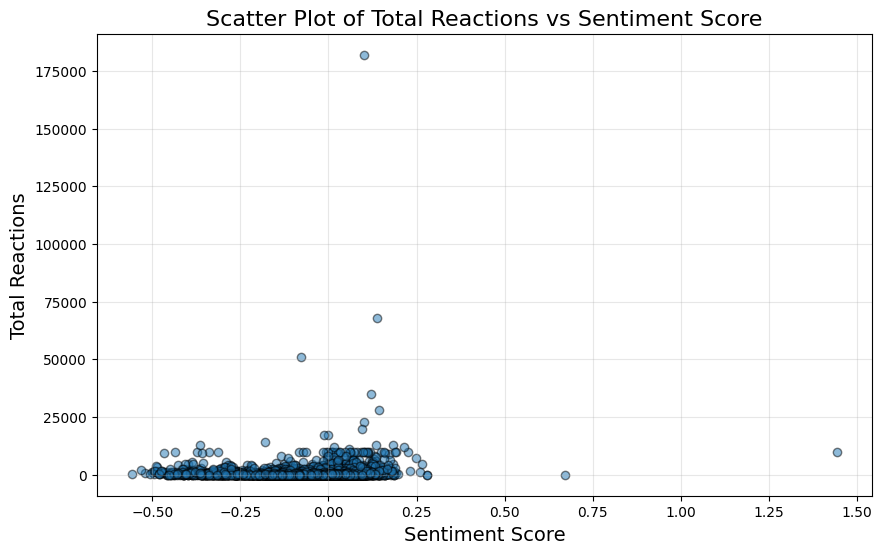

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df['sentiment_score'], df['total_reactions'], alpha=0.5, edgecolor='k')
plt.title('Scatter Plot of Total Reactions vs Sentiment Score', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Total Reactions', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

## **10. Plot 6: Scatter Plot of Total Comments vs Total Reactions**

We analyze the relationship between the number of comments and the total reactions.

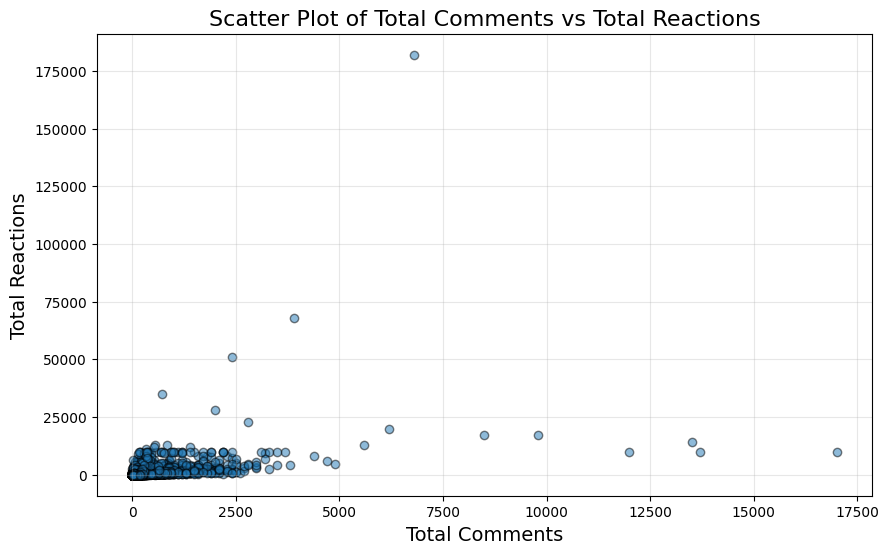

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(df['total_comments'], df['total_reactions'], alpha=0.5, edgecolor='k')
plt.title('Scatter Plot of Total Comments vs Total Reactions', fontsize=16)
plt.xlabel('Total Comments', fontsize=14)
plt.ylabel('Total Reactions', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

## **11. Plot 7: Reaction Ratios by Sentiment**

We create box plots to visualize the distribution of reaction ratios grouped by sentiment scores.

### **11.1 Prepare Data**

In [16]:
df.columns

Index(['news_org', 'title', 'summary', 'total_reactions',
       'article_screenshot_s3_link', 'reactions_screenshot_s3_link',
       'article_sc_date', 'reactions_sc_date', 'total_comments',
       'total_shares', 'total_like', 'total_love', 'total_haha', 'total_wow',
       'total_sad', 'total_angry', 'total_care', 'ratio_love', 'ratio_haha',
       'ratio_wow', 'ratio_sad', 'ratio_angry', 'ratio_care', 'cleaned_title',
       'cleaned_summary', 'vader_sentiment_score', 'embedding',
       'vader_sentiment_class', 'sentiment_score', 'headline_sentiment_class',
       'news_label'],
      dtype='object')

In [17]:
# Define the list of reaction ratio columns
reaction_ratios = [
    'ratio_love',
    'ratio_haha',
    'ratio_angry',
    'ratio_wow',
    'ratio_sad',
    'ratio_care'
]

# Melt the DataFrame to long format for easier plotting
df_long = df.melt(id_vars=['sentiment_score'], value_vars=reaction_ratios,
                  var_name='Reaction Type', value_name='Reaction Ratio')

### **11.2 Plotting**

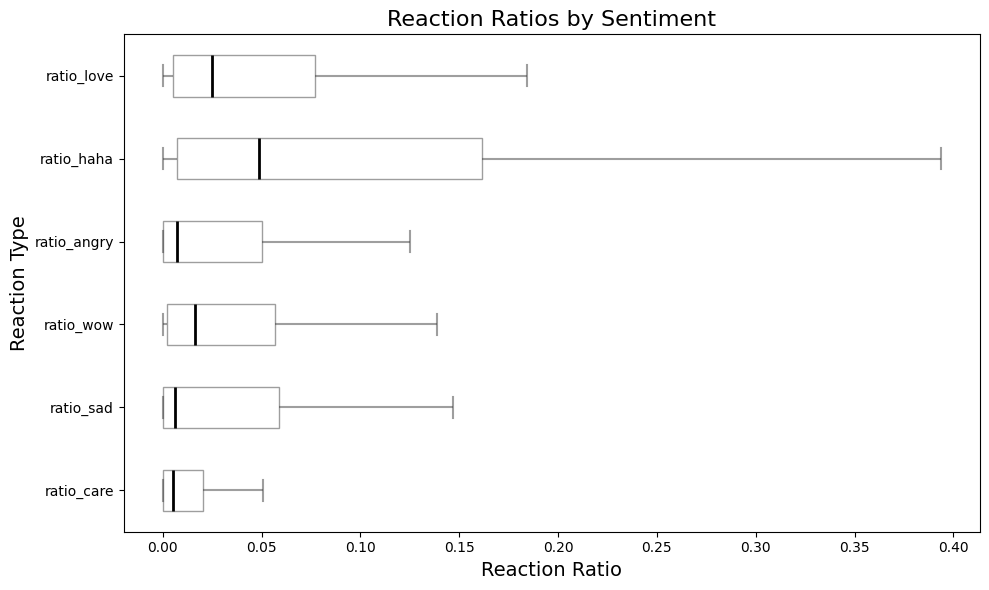

In [18]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_long,
    y='Reaction Type',
    x='Reaction Ratio',
    boxprops={'facecolor': 'white', 'alpha': 0.5},
    showfliers=False,
    whiskerprops={'linewidth': 1.5, 'alpha': 0.5},
    capprops={'linewidth': 1.5, 'alpha': 0.5},
    medianprops={'color': 'black', 'linewidth': 2},
    width=0.5
)

# Add labels and title
plt.title('Reaction Ratios by Sentiment', fontsize=16)
plt.xlabel('Reaction Ratio', fontsize=14)
plt.ylabel('Reaction Type', fontsize=14)
plt.tight_layout()
plt.show()

## **12. Additional Supporting Plots**

### **12.1 Distribution of Sentiment Scores**

We plot the distribution of sentiment scores to observe how they are spread across the dataset.

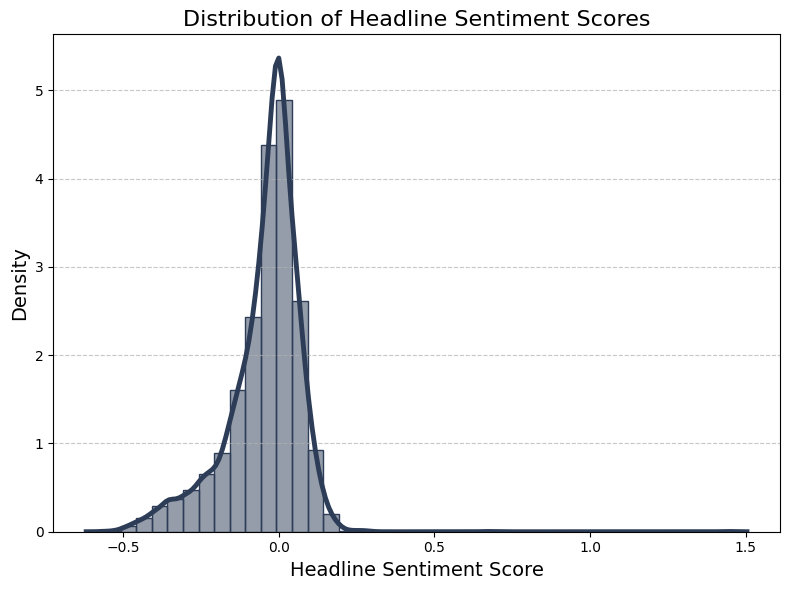

In [46]:
# Create the histogram and KDE plot
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment_score'], bins=40, color=fb_dark_blue, edgecolor=fb_dark_blue, stat='density', alpha=0.5)
sns.kdeplot(df['sentiment_score'], color=fb_dark_blue, linewidth=3.5)

# Add labels and title
plt.title('Distribution of Headline Sentiment Scores', fontsize=16)
plt.xlabel('Headline Sentiment Score', fontsize=14)
# plt.xlim(-0.2, 0.2)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and display the plot
plt.savefig(path_output_images + 'Distribution_of_Headline_Sentiment_Scores.png', transparent=True)
plt.show()

### **12.2 Distribution of Sentiment Classes**

We plot the distribution of sentiment classes to observe how they are spread across the dataset.

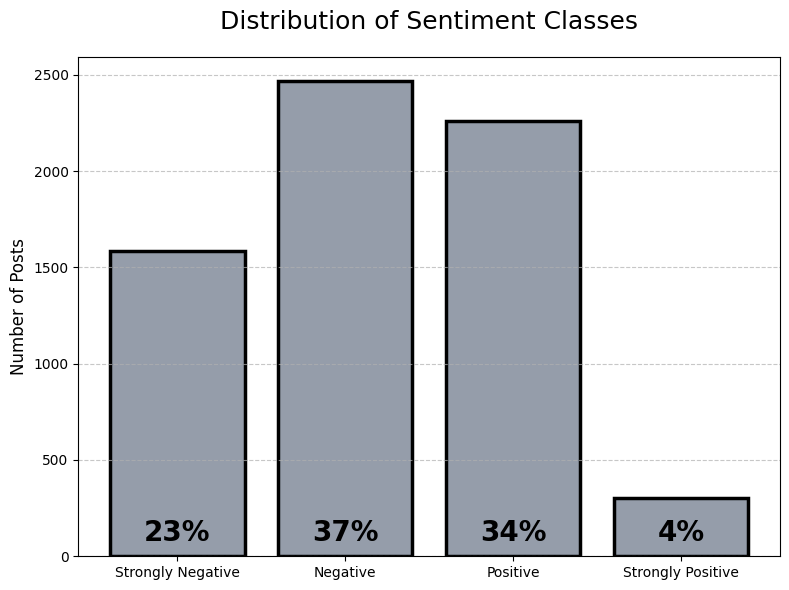

In [51]:

# Plot the distribution of sentiment classes
class_counts = df['headline_sentiment_class'].value_counts().sort_index()
total_posts = class_counts.sum()

# Define class labels
class_labels = ['Strongly Negative', 'Negative', 'Positive', 'Strongly Positive']

# Get the unique sentiment classes present in the data
unique_classes = class_counts.index

# Filter the class labels to only include those present in the data
class_labels = [label for i, label in enumerate(class_labels) if i in unique_classes]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index,
        class_counts.values,
        color='#959DAA',
        edgecolor='black',
        linewidth=2.5)


# Set the x-ticks to be the class labels
plt.xticks(class_counts.index, class_labels, rotation=0)  # Updated this line

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add labels and title
# plt.xlabel('Sentiment Class', size=12, color=plot_color)
plt.ylabel('Number of Posts', size=12, color=plot_color)
plt.title('Distribution of Sentiment Classes',
             size=18,
             color=plot_color,
             pad=20)

# Display the values on top of the bars
for index, value in zip(class_counts.index, class_counts.values):
    plt.text(index, 50, str(int(value/total_posts*100))+'%',
             ha='center',
             va='bottom',
        fontsize=20,
        color='black',
        weight='black')

plt.tight_layout()

# Save and display the plot
plt.savefig(path_output_images + 'Distribution_of_Sentiment_Classes.png', transparent=True)
plt.show()

### **12.3 Word Clouds for Positive and Negative Titles**

We generate word clouds to visualize the most frequent words in positive and negative news titles.

#### *12.3.1 Prepare Data*

In [23]:
# Define stop words (add custom stopwords to the NLTK stop words list)
custom_stop_words = set(stopwords.words('english')).union({
    'say', 'make', 'u', 'take', 'know', 'could', 'would', 'get',
    'new', 'day', 'man', 'woman', 'year', 'first', 'go', 'cnn', 'says',
    'boston', 'globe', 'found', '2023'
})

# Split the dataset into positive and negative titles
positive_titles = df[df['sentiment_score'] > 0]['title']
negative_titles = df[df['sentiment_score'] < 0]['title']

# Function to preprocess text: tokenize and remove stop words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalnum() and word not in custom_stop_words]

# Get word frequencies for positive and negative titles
def get_word_frequencies(titles):
    all_words = []
    for title in titles.dropna():
        all_words.extend(preprocess_text(title))
    return Counter(all_words)

positive_word_freq = get_word_frequencies(positive_titles)
negative_word_freq = get_word_frequencies(negative_titles)

#### *12.3.2 Plotting*

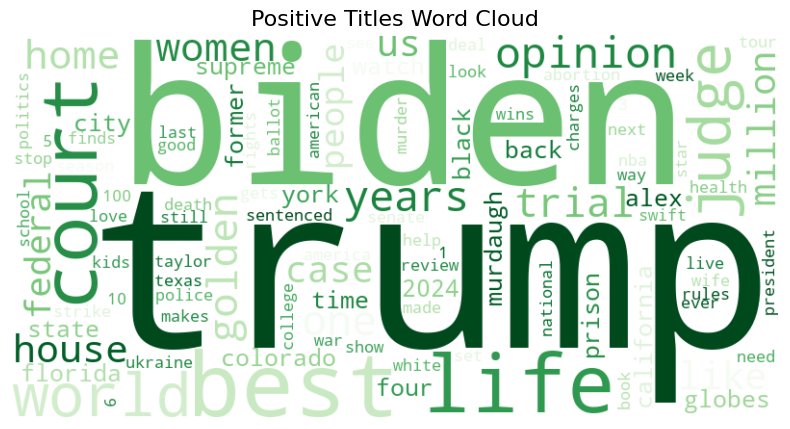

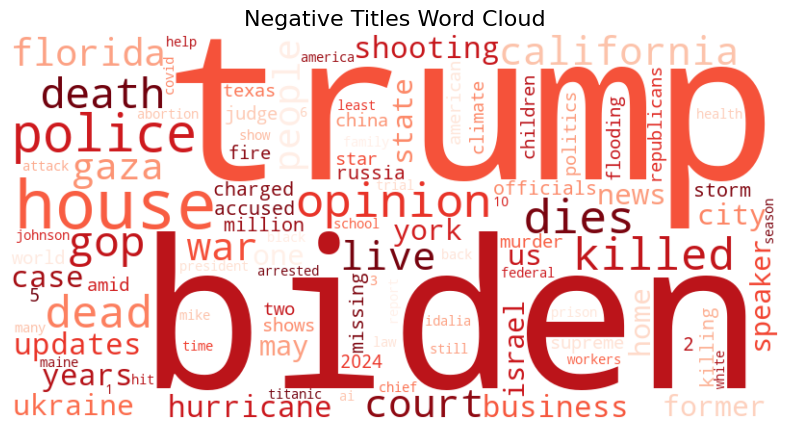

In [24]:
# Function to generate a word cloud
def plot_word_cloud(word_freq, title, color='blue'):
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', colormap=color,
        max_words=100
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Plot word clouds for positive and negative titles
plot_word_cloud(positive_word_freq, 'Positive Titles Word Cloud', color='Greens')
plot_word_cloud(negative_word_freq, 'Negative Titles Word Cloud', color='Reds')